In [1]:
import argparse
import logging
import random
import typing


import torch
from mmf.common.registry import registry
from mmf.utils.build import build_config, build_trainer
from mmf.utils.configuration import Configuration
from mmf.utils.distributed import distributed_init, get_rank, infer_init_method, is_xla
from mmf.utils.env import set_seed, setup_imports
from mmf.utils.flags import flags
from mmf.utils.general import log_device_names
from mmf.utils.logger import setup_logger, setup_very_basic_config
from mmf.trainers.mmf_trainer import MMFTrainer

setup_very_basic_config()

C:\ProgramData\Anaconda3\envs\mmf\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
C:\ProgramData\Anaconda3\envs\mmf\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import collections
import pandas as pd
from torchvision import transforms as T

import json
import os
from PIL import Image
import cv2

import pickle

In [3]:
import clip
from classes.transforms.CropCenter import CropCenter
from classes.transforms.ScaleMaxSideToSize import ScaleMaxSideToSize

In [4]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.transforms = transforms
        
    def find(self, id: int):  
        for row in self.data:
            if row['id'] == id:
                path = os.path.join(self.data_dir, row["img"])
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                text = row["text"][:77]
                label = row["label"]

                if self.transforms is not None:
                    image = self.transforms(image)

                return {'image':image, 'text':text, 'label':label, 'path':path}
        return None

In [5]:
CROP_SIZE=224
data_dir = r'E:\datasets\MADE\3_graduation\parthplc\archive\data\\'
train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model_clip, preprocess = clip.load("ViT-L/14", device=device)

MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

transforms = T.Compose([
    ScaleMaxSideToSize(CROP_SIZE),
    CropCenter(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])



In [7]:
def main(configuration, init_distributed=False, predict=False):
    print('main')
    # A reload might be needed for imports
    setup_imports()
    configuration.import_user_dir()
    config = configuration.get_config()

    
    if torch.cuda.is_available():
        torch.cuda.set_device(config.device_id)
        torch.cuda.init()

    if init_distributed:
        distributed_init(config)

    seed = config.training.seed
    config.training.seed = set_seed(seed if seed == -1 else seed + get_rank())
    registry.register("seed", config.training.seed)

    config = build_config(configuration)

    setup_logger(
        color=config.training.colored_logs, disable=config.training.should_not_log
    )
    logger = logging.getLogger("mmf_cli.run")
    # Log args for debugging purposes
    logger.info(configuration.args)
    logger.info(f"Torch version: {torch.__version__}")
    log_device_names()
    logger.info(f"Using seed {config.training.seed}")

    print('predict:',predict)
    print('config:',config)#['dataset_config']
    print(config['dataset_config']['hateful_memes']['data_dir'])
    
    
    
    trainer = MMFTrainer(config) #build_trainer(config)
    trainer.load()
    
    return trainer
    #if predict:
    #    trainer.inference()
    #else:
    #    trainer.train()


def distributed_main(device_id, configuration, predict=False):
    config = configuration.get_config()
    config.device_id = device_id

    if config.distributed.rank is None:
        config.distributed.rank = config.start_rank + device_id

    main(configuration, init_distributed=True, predict=predict)

def run(opts: typing.Optional[typing.List[str]] = None, predict: bool = False):
    print('run')
    """Run starts a job based on the command passed from the command line.
    You can optionally run the mmf job programmatically by passing an optlist as opts.

    Args:
        opts (typing.Optional[typing.List[str]], optional): Optlist which can be used.
            to override opts programmatically. For e.g. if you pass
            opts = ["training.batch_size=64", "checkpoint.resume=True"], this will
            set the batch size to 64 and resume from the checkpoint if present.
            Defaults to None.
        predict (bool, optional): If predict is passed True, then the program runs in
            prediction mode. Defaults to False.
    """
    setup_imports()

    opts = ['config=config.yaml', 
            'model=visual_bert', 
'checkpoint.resume_file=E:\\coding\\MADE-graduation-projects\\hateful_memes3\\SOTA\\mmf\\visual_bert\\predict\\visual_bert.ckpt',
            'checkpoint.resume_pretrained=False', 
            'run_type=val', 
            'dataset=hateful_memes', 
            'evaluation.predict=true']
    if opts is None:
        parser = flags.get_parser()
        args = parser.parse_args()
    else:
        args = argparse.Namespace(config_override=None)
        args.opts = opts

        
    print('********************************')
    print(args)
    print('********************************')
    
    configuration = Configuration(args)
    # Do set runtime args which can be changed by MMF
    configuration.args = args
    config = configuration.get_config()
    config.start_rank = 0
    if config.distributed.init_method is None:
        infer_init_method(config)

    config.device_id = 0
    return main(configuration, predict=predict)


mmfTrainer = run(predict=True)

mmfTrainer.model.eval()
mmfTrainer.model.is_pretrained = True

mmfTrainer.model.model.classifier = torch.nn.Sequential(*[mmfTrainer.model.model.classifier[i] for i in range(len(mmfTrainer.model.model.classifier) - 1)])

run
********************************
Namespace(config_override=None, opts=['config=config.yaml', 'model=visual_bert', 'checkpoint.resume_file=E:\\coding\\MADE-graduation-projects\\hateful_memes3\\SOTA\\mmf\\visual_bert\\predict\\visual_bert.ckpt', 'checkpoint.resume_pretrained=False', 'run_type=val', 'dataset=hateful_memes', 'evaluation.predict=true'])
********************************
2022-10-16T08:43:16 | mmf.utils.configuration: Overriding option config to config.yaml
2022-10-16T08:43:16 | mmf.utils.configuration: Overriding option model to visual_bert
2022-10-16T08:43:16 | mmf.utils.configuration: Overriding option checkpoint.resume_file to E:\coding\MADE-graduation-projects\hateful_memes3\SOTA\mmf\visual_bert\predict\visual_bert.ckpt
2022-10-16T08:43:16 | mmf.utils.configuration: Overriding option checkpoint.resume_pretrained to False
2022-10-16T08:43:16 | mmf.utils.configuration: Overriding option run_type to val
2022-10-16T08:43:16 | mmf.utils.configuration: Overriding option dat

C:\ProgramData\Anaconda3\envs\mmf\lib\site-packages\omegaconf\grammar_visitor.py:257: UserWarning: In the sequence `MMF_USER_DIR,` some elements are missing: please replace them with empty quoted strings. See https://github.com/omry/omegaconf/issues/572 for details.
  category=UserWarning,
C:\ProgramData\Anaconda3\envs\mmf\lib\site-packages\omegaconf\grammar_visitor.py:257: UserWarning: In the sequence `MMF_LOG_DIR,` some elements are missing: please replace them with empty quoted strings. See https://github.com/omry/omegaconf/issues/572 for details.
  category=UserWarning,
C:\ProgramData\Anaconda3\envs\mmf\lib\site-packages\omegaconf\grammar_visitor.py:257: UserWarning: In the sequence `MMF_REPORT_DIR,` some elements are missing: please replace them with empty quoted strings. See https://github.com/omry/omegaconf/issues/572 for details.
  category=UserWarning,
C:\ProgramData\Anaconda3\envs\mmf\lib\site-packages\omegaconf\grammar_visitor.py:257: UserWarning: In the sequence `MMF_TENSOR

main
2022-10-16T08:43:16 | mmf: Logging to: E:\mmf\save\train.log
2022-10-16T08:43:16 | mmf_cli.run: Namespace(config_override=None, opts=['config=config.yaml', 'model=visual_bert', 'checkpoint.resume_file=E:\\coding\\MADE-graduation-projects\\hateful_memes3\\SOTA\\mmf\\visual_bert\\predict\\visual_bert.ckpt', 'checkpoint.resume_pretrained=False', 'run_type=val', 'dataset=hateful_memes', 'evaluation.predict=true'])
2022-10-16T08:43:16 | mmf_cli.run: Torch version: 1.9.0
2022-10-16T08:43:16 | mmf_cli.run: Using seed 48053078
predict: True
config: {'config_version': 1.0, 'training': {'trainer': 'base_trainer', 'seed': 48053078, 'experiment_name': 'run', 'max_updates': 22000, 'max_epochs': None, 'log_interval': 100, 'logger_level': 'info', 'log_format': 'simple', 'log_detailed_config': False, 'should_not_log': False, 'colored_logs': True, 'tensorboard': False, 'cudnn_benchmark': False, 'wandb': {'enabled': False, 'entity': None, 'project': 'mmf', 'name': 'run', 'log_checkpoint': False}, '

e:\coding\mmf\mmf\utils\configuration.py:582: UserWarning: Device specified is 'cuda' but cuda is not present. Switching to CPU version.
  "Device specified is 'cuda' but cuda is not present. "
C:\ProgramData\Anaconda3\envs\mmf\lib\site-packages\omegaconf\grammar_visitor.py:257: UserWarning: In the sequence `MMF_WANDB_LOGDIR,` some elements are missing: please replace them with empty quoted strings. See https://github.com/omry/omegaconf/issues/572 for details.
  category=UserWarning,
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\notebook/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob

2022-10-16T08:43:26 | mmf.datasets.multi_datamodule: Multitasking disabled by default for single dataset training
2022-10-16T08:43:26 | mmf.datasets.multi_datamodule: Multitasking disabled by default for single dataset training
2022-10-16T08:43:26 | mmf.datasets.multi_datamodule: Multitasking disabled by default for single dataset training
2022-10-16T08:43:26 | mmf.trainers.mmf_trainer: Loading model


Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "bert_model_name": "bert-base-uncased",
  "bypass_transformer": false,
  "classifier_dropout": null,
  "embedding_strategy": "plain",
  "finetune_lr_multiplier": 1,
  "freeze_base": false,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "losses": [
    "cross_entropy"
  ],
  "max_position_embeddings": 512,
  "model": "visual_bert",
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_strategy": "default",
  "position_embedding_type": "absolute",
  "random_initialize": false,
  "special_visual_initialize": true,
  "training_head_type": "classification",
  "transformers_version": "4.10.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "visual_embedding_dim": 2048,
  "vocab_size": 30522,
  "zerobias": false
}

loading

2022-10-16T08:43:29 | mmf.trainers.mmf_trainer: Loading optimizer
*** {'config_version': 1.0, 'training': {'trainer': 'base_trainer', 'seed': 48053078, 'experiment_name': 'run', 'max_updates': 22000, 'max_epochs': None, 'log_interval': 100, 'logger_level': 'info', 'log_format': 'simple', 'log_detailed_config': False, 'should_not_log': False, 'colored_logs': True, 'tensorboard': False, 'cudnn_benchmark': False, 'wandb': {'enabled': False, 'entity': None, 'project': 'mmf', 'name': 'run', 'log_checkpoint': False}, 'batch_size': 32, 'batch_size_per_device': None, 'update_frequency': 1, 'num_workers': 4, 'fast_read': False, 'dataset_size_proportional_sampling': True, 'pin_memory': False, 'persistent_workers': True, 'checkpoint_interval': 1000, 'evaluation_interval': 1000, 'clip_gradients': False, 'clip_norm_mode': 'all', 'early_stop': {'enabled': False, 'patience': 4000, 'criteria': 'hateful_memes/roc_auc', 'minimize': False}, 'lr_scheduler': True, 'lr_steps': [], 'lr_ratio': 0.1, 'use_warm

In [8]:
def get_features_clip(model_clip, ids, dataset):
    batch_features = []
    with torch.no_grad():
        for id in ids:
            data = dataset.find(id)
            if data is None:
                raise Exception(f'{id} not found')

            image_input = data['image'].unsqueeze(0)
            text_tokens = clip.tokenize(data['text'])

            image_features = model_clip.encode_image(image_input).type(torch.float).cpu()
            text_features = model_clip.encode_text(text_tokens).type(torch.float).cpu()

            features = torch.cat([image_features, text_features], dim=1)

            batch_features.extend(features)

    return torch.vstack(batch_features)

def get_features_mmf(model, batch, out_features):
    with torch.no_grad():            
        output = model(batch)
        
    batch_size = batch['targets'].shape[0]
    features = output['scores'].flatten().reshape((batch_size, out_features))
        
    return features

def get_features(model_mmf, dataloader, out_features, model_clip, dataset):
    all_features = []
    all_labels = []
    
    for batch in tqdm(dataloader):        
        features_mmf = get_features_mmf(model_mmf, batch, 768)
        features_clip = get_features_clip(model_clip, batch['id'], dataset)
        features = torch.cat([features_mmf, features_clip], dim=1)
        
        labels = batch['targets']        
        
        all_features.extend(features)
        all_labels.extend(labels)

    return all_features, all_labels



In [9]:
for batch in mmfTrainer.val_loader:
    break
batch

SampleList([('text',
             [['[CLS]',
               'this',
               'is',
               'how',
               'muslims',
               'celebrate',
               'new',
               'year',
               '[SEP]'],
              ['[CLS]',
               '"',
               'white',
               'privilege',
               'the',
               'privilege',
               'of',
               'being',
               'called',
               '"',
               'racist',
               '"',
               'by',
               'other',
               'people',
               'who',
               'see',
               'nothing',
               'else',
               'about',
               'you',
               'except',
               'the',
               'color',
               'of',
               'your',
               'skin',
               '[SEP]'],
              ['[CLS]',
               'this',
               'is',
               'el',
               'paso',


In [10]:
batch['id']

tensor([32691, 69150, 25061, 32049, 89642, 56124,  1268, 75142, 19508, 10386,
        18726, 52603, 29873, 57369, 16749, 64891, 65832, 95604, 14389, 83920,
        65342, 78914, 50261, 53769, 61503, 56473,  3567, 59170,  2145,  5213,
        68409, 91405], dtype=torch.int32)

In [11]:
x = get_features_mmf(mmfTrainer.model, batch, 768)
x.shape

torch.Size([32, 768])

In [12]:
#x2 = get_features_clip(model_clip, batch['id'])
#x2.shape

In [13]:
#torch.cat([x, x2], dim=1).shape

In [14]:
#all_features = []
#all_features.extend(torch.cat([x, x2], dim=1))

In [15]:
train_dataset = HatefulMemesDataset(train_path, transforms)
val_dataset = HatefulMemesDataset(dev_path, transforms)

val_dataset.find(41890)

{'image': tensor([[[-0.8335, -0.6109, -0.5596,  ...,  0.8789,  0.8961,  0.5878],
          [-0.5424, -0.3027, -0.2684,  ...,  1.3584,  1.3242,  0.9474],
          [-0.5253, -0.2856, -0.2684,  ...,  1.2557,  1.2043,  0.8276],
          ...,
          [-1.5014, -0.7479,  0.4851,  ..., -1.0390, -1.3130, -1.6042],
          [-1.5870, -0.6281,  0.7077,  ..., -1.1760, -1.3987, -1.4843],
          [-1.7583, -0.8678,  0.1426,  ..., -0.9705, -1.4500, -1.4500]],
 
         [[-0.3025, -0.0224,  0.0126,  ...,  0.7129,  0.7304,  0.4503],
          [ 0.0476,  0.3452,  0.3803,  ...,  1.1856,  1.1681,  0.8179],
          [ 0.0476,  0.3452,  0.3803,  ...,  1.1331,  1.0805,  0.7479],
          ...,
          [-1.4755, -0.9153, -0.0049,  ..., -1.7556, -1.7906, -1.7381],
          [-1.5455, -0.7752,  0.1877,  ..., -1.7556, -1.7031, -1.7031],
          [-1.7381, -1.0553, -0.3550,  ..., -1.6331, -1.6856, -1.7381]],
 
         [[ 0.5311,  0.8622,  0.9145,  ...,  1.1585,  1.1411,  0.8274],
          [ 0.9494,

In [16]:
train_dataset.find(97261)

{'image': tensor([[[-1.7240, -1.7240, -1.7240,  ..., -1.8268, -1.8268, -1.8268],
          [-1.7069, -1.6898, -1.7240,  ..., -1.8097, -1.8268, -1.8268],
          [-1.6898, -1.7069, -1.6727,  ..., -1.8097, -1.8097, -1.8097],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],
 
         [[-1.6331, -1.6331, -1.6331,  ..., -1.7906, -1.7731, -1.7906],
          [-1.5805, -1.5805, -1.5980,  ..., -1.7906, -1.7906, -1.7906],
          [-1.5805, -1.5805, -1.5805,  ..., -1.7906, -1.8081, -1.7906],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],
 
         [[-0.9853, -1.0027, -1.0201,  ..., -1.2119, -1.1770, -1.1770],
          [-0.9504,

In [17]:
if True:
    with open('features_train.pkl', 'rb') as f:
        features_train = pickle.load(f)
        
    with open('labels_train.pkl', 'rb') as f:
        labels_train = pickle.load(f)
        
    with open('features_val.pkl', 'rb') as f:
        features_val = pickle.load(f)
        
    with open('labels_val.pkl', 'rb') as f:
        labels_val = pickle.load(f)        
else:
    features_train, labels_train = get_features(mmfTrainer.model, mmfTrainer.train_loader, 768, model_clip, train_dataset)
    features_val, labels_val = get_features(mmfTrainer.model, mmfTrainer.val_loader, 768, model_clip, val_dataset)

    with open('features_train.pkl', 'wb') as f:
        pickle.dump(features_train, f)

    with open('labels_train.pkl', 'wb') as f:
        pickle.dump(labels_train, f)

    with open('features_val.pkl', 'wb') as f:
        pickle.dump(features_val, f)

    with open('labels_val.pkl', 'wb') as f:
        pickle.dump(labels_val, f)

In [18]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
            
    def __getitem__(self, index: int):            
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return len(self.features)

In [19]:
features_train_dataset = FeaturesDataset(features_train, labels_train)
features_val_dataset = FeaturesDataset(features_val, labels_val)

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    best_model_name = None
    loss_history = []
    train_history = []
    val_history = []
    top_val_accuracy = 0.64 
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x=x.type(torch.float).cpu()
            y = y.type(torch.float).cpu()
            model = model.cpu()
            prediction = model(x)    
            loss_value = loss(prediction, y.type(torch.long))
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler != None:
            scheduler.step()

        print("Epoch: %i lr: %f; Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), ave_loss, train_accuracy, val_accuracy))

  
        if val_accuracy > top_val_accuracy:
            top_val_accuracy = val_accuracy
            model_name = f'classifier_{epoch}_{round(val_accuracy, 3)}.ckpt'
            best_model_name = model_name
            torch.save(model, open(model_name, 'wb'))
            print("saved", model_name)

    return loss_history, train_history, val_history, best_model_name
        
    
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0 
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]            

    val_accuracy = float(correct_samples) / total_samples
         
    return val_accuracy

In [21]:
input_shape = features_train[0].shape[0]
num_classes = 2
print(input_shape)

2304


In [22]:
torch.manual_seed(1024)

shape = 256
nn_model = nn.Sequential(
            nn.Linear(input_shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, num_classes),
            )

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 30, scheduler)
print('end!')


Sequential(
  (0): Linear(in_features=2304, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)
Epoch: 0 lr: 0.010000; Average loss: 0.231014, Train accuracy: 0.902235, Val accuracy: 0.646000
saved classifier_0_0.646.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.146647, Train accuracy: 0.949059, Val accuracy: 0.646000
Epoch: 2 lr: 0.010000; Average loss: 0.145900, Train accuracy: 0.949647, Val accuracy: 0.644000
Epoch: 3 lr: 0.010000; Average loss: 0.140468, Train accuracy: 0.951294, Val accuracy: 0.656000
saved classifier_3_0.656.ckpt
Epoch: 4 lr: 0.010000; Average loss: 0.133839, Train accura

Epoch: 77 lr: 0.002097; Average loss: 0.016614, Train accuracy: 0.993176, Val accuracy: 0.674000
Epoch: 78 lr: 0.002097; Average loss: 0.017047, Train accuracy: 0.992588, Val accuracy: 0.680000
Epoch: 79 lr: 0.001678; Average loss: 0.019260, Train accuracy: 0.992471, Val accuracy: 0.686000
Epoch: 80 lr: 0.001678; Average loss: 0.019073, Train accuracy: 0.992118, Val accuracy: 0.686000
Epoch: 81 lr: 0.001678; Average loss: 0.016616, Train accuracy: 0.992588, Val accuracy: 0.686000
Epoch: 82 lr: 0.001678; Average loss: 0.017107, Train accuracy: 0.993412, Val accuracy: 0.680000
Epoch: 83 lr: 0.001678; Average loss: 0.015363, Train accuracy: 0.993294, Val accuracy: 0.680000
Epoch: 84 lr: 0.001678; Average loss: 0.017975, Train accuracy: 0.992588, Val accuracy: 0.688000
Epoch: 85 lr: 0.001678; Average loss: 0.015562, Train accuracy: 0.993882, Val accuracy: 0.682000
Epoch: 86 lr: 0.001678; Average loss: 0.014110, Train accuracy: 0.993529, Val accuracy: 0.680000
Epoch: 87 lr: 0.001678; Averag

Epoch: 161 lr: 0.000281; Average loss: 0.008180, Train accuracy: 0.996471, Val accuracy: 0.658000
Epoch: 162 lr: 0.000281; Average loss: 0.007518, Train accuracy: 0.996471, Val accuracy: 0.646000
Epoch: 163 lr: 0.000281; Average loss: 0.008355, Train accuracy: 0.996118, Val accuracy: 0.646000
Epoch: 164 lr: 0.000281; Average loss: 0.008177, Train accuracy: 0.996118, Val accuracy: 0.650000
Epoch: 165 lr: 0.000281; Average loss: 0.008009, Train accuracy: 0.996235, Val accuracy: 0.646000
Epoch: 166 lr: 0.000281; Average loss: 0.006942, Train accuracy: 0.997059, Val accuracy: 0.644000
Epoch: 167 lr: 0.000281; Average loss: 0.007288, Train accuracy: 0.997059, Val accuracy: 0.648000
Epoch: 168 lr: 0.000281; Average loss: 0.007367, Train accuracy: 0.996941, Val accuracy: 0.658000
Epoch: 169 lr: 0.000225; Average loss: 0.008191, Train accuracy: 0.996000, Val accuracy: 0.656000
Epoch: 170 lr: 0.000225; Average loss: 0.006597, Train accuracy: 0.997529, Val accuracy: 0.652000
Epoch: 171 lr: 0.000

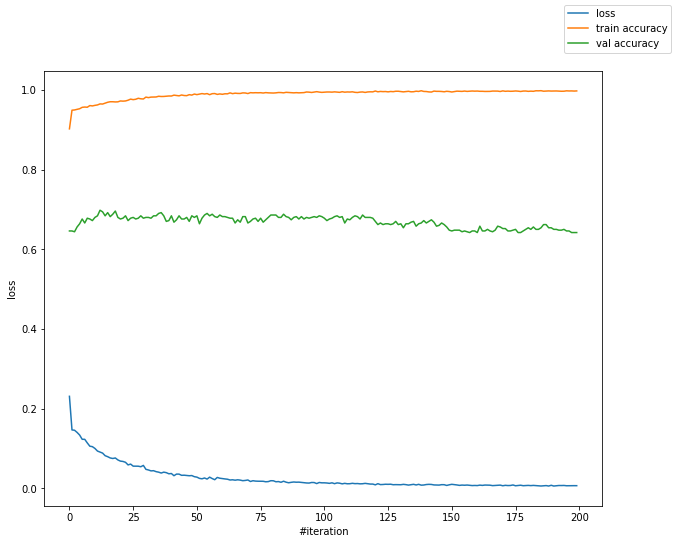

In [23]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [24]:
print("best model:", best_model_name)
best_model = torch.load(open(best_model_name, 'rb'))


best model: classifier_12_0.698.ckpt


In [25]:
best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())
print(acc_score, auc_score)

0.698 0.7452


0.7452


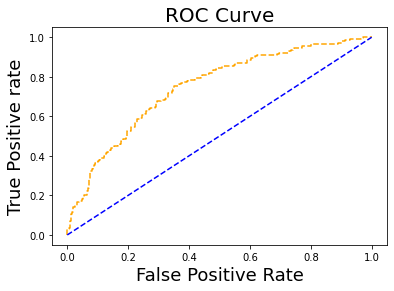

In [26]:
fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

In [27]:
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=2)):
    print(x.shape)
    break
    
x[ : , : 768].shape, x[ : , 768 : ].shape
        

torch.Size([2, 2304])


(torch.Size([2, 768]), torch.Size([2, 1536]))

In [28]:
mmf_input_dim = 768
clip_input_dim = 1536

hid_input_dim = 256


mmf_layer = nn.Sequential(
    nn.Linear(mmf_input_dim, mmf_input_dim),
    nn.BatchNorm1d(mmf_input_dim),
    nn.ReLU()
)

clip_layer = nn.Sequential(
    nn.Linear(clip_input_dim, clip_input_dim),
    nn.BatchNorm1d(clip_input_dim),
    nn.ReLU()
)

last_layer = nn.Sequential(
    nn.Linear(mmf_input_dim + clip_input_dim, hid_input_dim),
    nn.Dropout(0.66),
    nn.BatchNorm1d(hid_input_dim),
    nn.ReLU(inplace=True),    

    nn.Linear(hid_input_dim, hid_input_dim),
    nn.Dropout(0.66),
    nn.BatchNorm1d(hid_input_dim),
    nn.ReLU(inplace=True),    

    nn.Linear(hid_input_dim, num_classes),
    )


     

In [29]:
   
mmf_input = x[ : , : 768]
clip_input = x[ : , 768 : ]

mmf_output = mmf_layer(mmf_input)
clip_output = clip_layer(clip_input)        



In [30]:
mmf_output.shape, clip_output.shape

(torch.Size([2, 768]), torch.Size([2, 1536]))

In [31]:
torch.cat([mmf_output, clip_output], dim=1).shape

torch.Size([2, 2304])

In [32]:
output = torch.cat([mmf_output, clip_output], dim=1)
output = last_layer(output)

In [33]:
class NNModel(nn.Module):
    def __init__(self, mmf_input_dim, clip_input_dim, dropout, hid_input_dim, num_classes):
        super().__init__()
        
        self.mmf_input_dim = mmf_input_dim
        self.clip_input_dim = clip_input_dim
        
        self.mmf_layer = nn.Sequential(
            nn.Linear(mmf_input_dim, mmf_input_dim),
            nn.ReLU()
        )

        self.clip_layer = nn.Sequential(
            nn.Linear(clip_input_dim, clip_input_dim),
            nn.ReLU()
        )
        
        self.last_layer = nn.Sequential(
            nn.Linear(clip_input_dim, hid_input_dim),# mmf_input_dim+ clip_input_dim
            nn.Dropout(0.66),
            nn.BatchNorm1d(hid_input_dim),
            nn.ReLU(inplace=True),    
    
            #nn.Linear(hid_input_dim, hid_input_dim),
            #nn.Dropout(0.66),
            #nn.BatchNorm1d(hid_input_dim),
            #nn.ReLU(inplace=True),    
    
            nn.Linear(hid_input_dim, num_classes),
            )

       
        
    def forward(self, input):
        mmf_input = input[ : , : self.mmf_input_dim]
        clip_input = input[ : , self.mmf_input_dim : ]
        
        mmf_output = self.mmf_layer(mmf_input)
        clip_output = self.clip_layer(clip_input)  
        
        output = torch.cat([mmf_output, clip_output], dim=1)
        output = self.last_layer(clip_output)

        return output

In [34]:
torch.manual_seed(1024)

nn_model = NNModel(768, 1536, 0.66, 256, 2)

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 30, scheduler)
print('end!')


NNModel(
  (mmf_layer): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): ReLU()
  )
  (clip_layer): Sequential(
    (0): Linear(in_features=1536, out_features=1536, bias=True)
    (1): ReLU()
  )
  (last_layer): Sequential(
    (0): Linear(in_features=1536, out_features=256, bias=True)
    (1): Dropout(p=0.66, inplace=False)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)
Epoch: 0 lr: 0.010000; Average loss: 0.614919, Train accuracy: 0.678941, Val accuracy: 0.664000
saved classifier_0_0.664.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.499904, Train accuracy: 0.756000, Val accuracy: 0.682000
saved classifier_1_0.682.ckpt
Epoch: 2 lr: 0.010000; Average loss: 0.458095, Train accuracy: 0.784706, Val accuracy: 0.696000
saved classifier_2_0.696.ckpt
Epoch: 3 lr: 0.010000; Average loss: 0.420060, Train accuracy: 0.807765, Val 

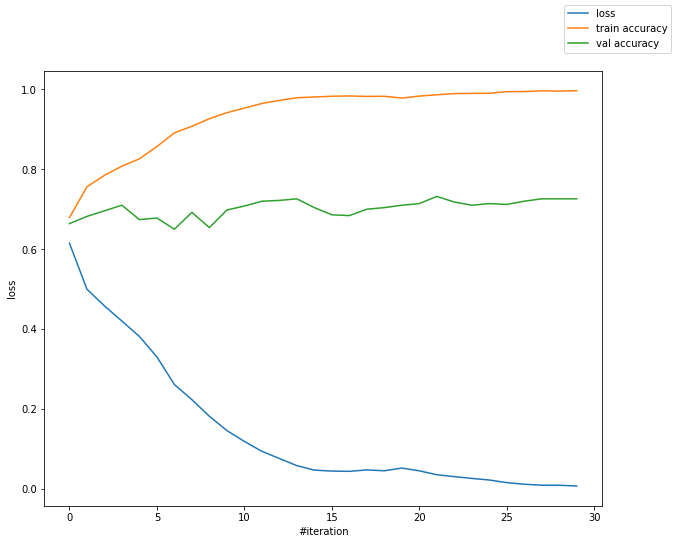

best model: classifier_21_0.732.ckpt
0.732 0.798672
0.798672


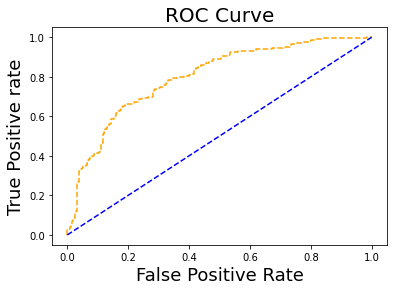

In [35]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

print("best model:", best_model_name)
best_model = torch.load(open(best_model_name, 'rb'))

best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())
print(acc_score, auc_score)

fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

NNModel(
  (mmf_layer): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): Dropout(p=0.66, inplace=False)
    (2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=768, out_features=768, bias=True)
  )
  (clip_layer): Sequential(
    (0): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1536, out_features=128, bias=True)
  )
  (last_layer): Sequential(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): Dropout(p=0.66, inplace=False)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Epoch: 0 lr: 0.010000; Average loss: 0.227508, Train accuracy: 0.910353, Val accuracy: 0.650000
saved classifier_0_0.65.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.152412, Train

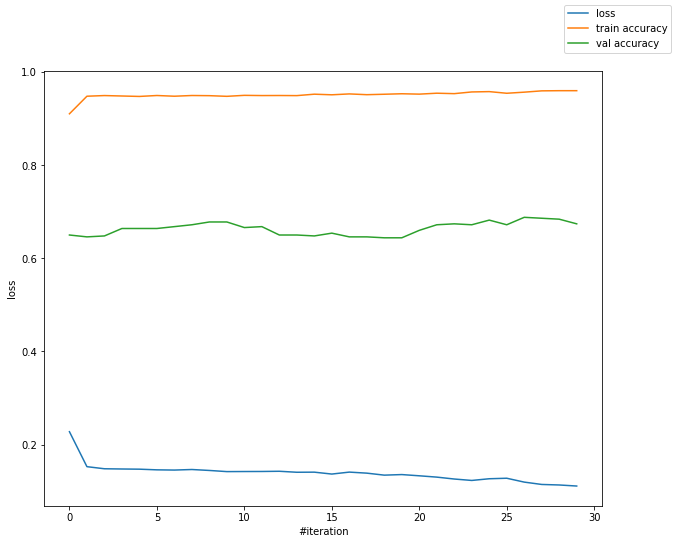

best model: classifier_26_0.688.ckpt
0.688 0.7477119999999999
0.7477119999999999


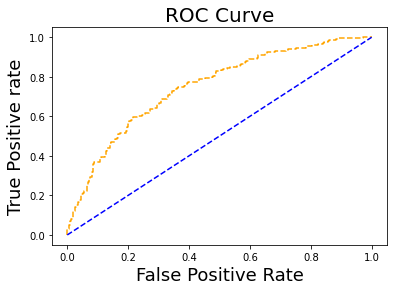

In [36]:
class NNModel(nn.Module):
    def __init__(self, mmf_input_dim, clip_input_dim, dropout, hid_input_dim, num_classes):
        super().__init__()
        
        self.mmf_input_dim = mmf_input_dim
        self.clip_input_dim = clip_input_dim
        
        self.mmf_layer = nn.Sequential(
            nn.Linear(mmf_input_dim, mmf_input_dim),
            nn.Dropout(0.66),
            nn.BatchNorm1d(mmf_input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(mmf_input_dim, mmf_input_dim),
            )


        self.clip_layer = nn.Sequential(
            #nn.Linear(clip_input_dim, hid_input_dim),
            #nn.Dropout(0.66),
            nn.BatchNorm1d(clip_input_dim),
            #nn.ReLU(inplace=True),
            nn.Linear(clip_input_dim, hid_input_dim),
        )
        
        self.last_layer = nn.Sequential(
            nn.Linear(mmf_input_dim + clip_input_dim, hid_input_dim),# 
            nn.Dropout(0.66),
            nn.BatchNorm1d(hid_input_dim),
            nn.ReLU(inplace=True),        
            nn.Linear(hid_input_dim, num_classes),
            )

       
        
    def forward(self, input):
        mmf_input = input[ : , : self.mmf_input_dim]
        clip_input = input[ : , self.mmf_input_dim : ]
        
        mmf_output = self.mmf_layer(mmf_input)
        clip_output = clip_input#self.clip_layer(clip_input)  
        
        output = torch.cat([mmf_output, clip_output], dim=1)
        output = self.last_layer(output)

        return output
    
    
torch.manual_seed(1024)

nn_model = NNModel(768, 1536, 0.66, 128, 2)

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 30, scheduler)
print('end!')


fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

print("best model:", best_model_name)
best_model = torch.load(open(best_model_name, 'rb'))

best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())
print(acc_score, auc_score)

fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();